# Importando Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
from matplotlib.ticker import MultipleLocator

import pyarrow as pa
import pyarrow.parquet as pq

from pyspark.sql import functions as F # Importando as funções sql 
from pyspark.sql.types import *

## Criando Sessão Spark

In [2]:

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

24/06/16 11:58:09 WARN Utils: Your hostname, codespaces-c15f91 resolves to a loopback address: 127.0.0.1; using 172.16.5.4 instead (on interface eth0)
24/06/16 11:58:09 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/16 11:58:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# PIB

## Importando os Dados

In [3]:
dir = '/workspaces/TCC_MLaaS_PIB_ANAC/base_dados/PIB/BaseDados_PIB_2009_2021.parquet.gzip'
pib = spark.read.parquet(dir)


## Explorando os Dados

In [4]:

pib.printSchema()

pib.show(5)

root
 |-- Ano: long (nullable = true)
 |-- Nome_UF: string (nullable = true)
 |-- Cod_Cidade: string (nullable = true)
 |-- Nome_Cidade: string (nullable = true)
 |-- Valor_Agropecuaria: double (nullable = true)
 |-- Valor_Industria: double (nullable = true)
 |-- Valor_Servicos: double (nullable = true)
 |-- Governo: double (nullable = true)
 |-- Total: double (nullable = true)
 |-- Impostos: double (nullable = true)
 |-- PIB: double (nullable = true)
 |-- PIB_per_capita: double (nullable = true)
 |-- __index_level_0__: long (nullable = true)

+----+-------+----------+--------------------+------------------+---------------+--------------+----------+----------+---------+----------+--------------+-----------------+
| Ano|Nome_UF|Cod_Cidade|         Nome_Cidade|Valor_Agropecuaria|Valor_Industria|Valor_Servicos|   Governo|     Total| Impostos|       PIB|PIB_per_capita|__index_level_0__|
+----+-------+----------+--------------------+------------------+---------------+--------------+--------

## Tratamento dos Dados

In [5]:
# Deletando coluna desnecessária.
pib = pib.drop('__index_level_0__')

In [6]:
#Conferindo se foi excluída.
pib.schema

StructType([StructField('Ano', LongType(), True), StructField('Nome_UF', StringType(), True), StructField('Cod_Cidade', StringType(), True), StructField('Nome_Cidade', StringType(), True), StructField('Valor_Agropecuaria', DoubleType(), True), StructField('Valor_Industria', DoubleType(), True), StructField('Valor_Servicos', DoubleType(), True), StructField('Governo', DoubleType(), True), StructField('Total', DoubleType(), True), StructField('Impostos', DoubleType(), True), StructField('PIB', DoubleType(), True), StructField('PIB_per_capita', DoubleType(), True)])

In [7]:
pib.show(5)

+----+-------+----------+--------------------+------------------+---------------+--------------+----------+----------+---------+----------+--------------+
| Ano|Nome_UF|Cod_Cidade|         Nome_Cidade|Valor_Agropecuaria|Valor_Industria|Valor_Servicos|   Governo|     Total| Impostos|       PIB|PIB_per_capita|
+----+-------+----------+--------------------+------------------+---------------+--------------+----------+----------+---------+----------+--------------+
|2002|     RO|  Rondônia|Alta Floresta D'O...|         27013.223|       9376.871|     24651.113| 42700.523|103741.729| 7549.266|111290.995|       4047.83|
|2002|     RO|  Rondônia|           Ariquemes|         28590.178|      99922.936|    161851.549|116562.182|406926.845|42665.972|449592.816|       5667.37|
|2002|     RO|  Rondônia|              Cabixi|         10883.801|       1961.907|      5128.876| 11925.001| 29899.585| 1867.935|  31767.52|       4246.99|
|2002|     RO|  Rondônia|              Cacoal|         32810.376|     

## Agrupando Valores

In [8]:

g_pib = pib.groupBy("Ano")\
        .agg((F.sum("Valor_Agropecuaria")/F.lit(1_000_000_000)).alias('Agropecuaria'),\
             (F.sum('Valor_Industria')/F.lit(1_000_000_000)).alias('Industria'),\
             (F.sum('Valor_Servicos')/F.lit(1_000_000_000)).alias('Servicos'),\
             (F.sum('Impostos')/F.lit(1_000_000_000)).alias('Impostos'),\
             (F.sum('Governo')/F.lit(1_000_000_000)).alias('Governo'))\
        .orderBy("Ano", ascending=True)\
        .toPandas()

## Plotando o Gráfico do PIB

In [9]:
fig_pib = g_pib.melt('Ano',var_name = 'PIB', value_name = 'R$ em Bi')

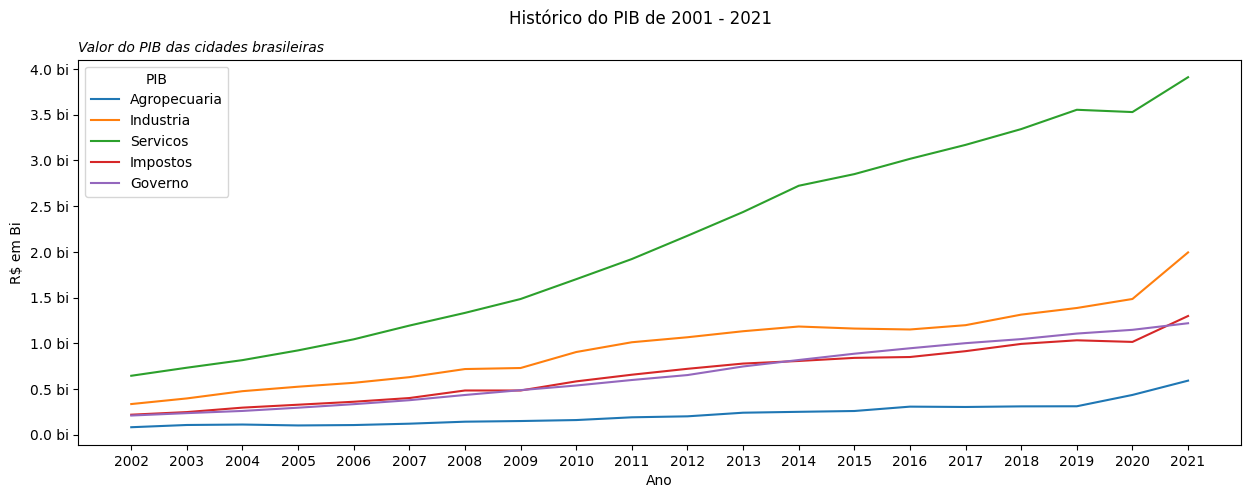

In [10]:


fig = plt.figure(figsize=(15,5))

fig.suptitle("Histórico do PIB de 2001 - 2021")

ax = fig.add_subplot()
ax.set_title('Valor do PIB das cidades brasileiras', loc='left', fontstyle='oblique', fontsize='medium')
sns.lineplot(x='Ano',y='R$ em Bi',hue='PIB',data=fig_pib)
ax.yaxis.set_major_formatter('{x:1.1f} bi')
ax.xaxis.set_major_locator(MultipleLocator(1))



# ANAC

## Importando os Dados


In [11]:

raw_Anac = spark.read.parquet('/workspaces/TCC_MLaaS_PIB_ANAC/base_dados/PassagensAereas/BaseDados_PassagensAereas.parquet.gzip')

raw_Anac

DataFrame[Ano: bigint, Mes: bigint, Empresa: string, Origem: string, Destino: string, Tarifa: string, Assentos: bigint, __index_level_0__: bigint]

## Explorando os Dados

In [12]:
raw_Anac.printSchema()
raw_Anac.show(5)


root
 |-- Ano: long (nullable = true)
 |-- Mes: long (nullable = true)
 |-- Empresa: string (nullable = true)
 |-- Origem: string (nullable = true)
 |-- Destino: string (nullable = true)
 |-- Tarifa: string (nullable = true)
 |-- Assentos: long (nullable = true)
 |-- __index_level_0__: long (nullable = true)



+----+---+-------+------+-------+------+--------+-----------------+
| Ano|Mes|Empresa|Origem|Destino|Tarifa|Assentos|__index_level_0__|
+----+---+-------+------+-------+------+--------+-----------------+
|2002|  1|    GLO|  SBPA|   SBBR|397,00|      51|                0|
|2002|  1|    GLO|  SBSV|   SBRF|272,00|       5|                1|
|2002|  1|    GLO|  SBFL|   SBGL|223,00|     196|                2|
|2002|  1|    GLO|  SBGL|   SBSP| 96,00|     615|                3|
|2002|  1|    GLO|  SBGL|   SBRF|340,00|     297|                4|
+----+---+-------+------+-------+------+--------+-----------------+
only showing top 5 rows



O campo **Tarifa** está com o formato string, para alterar, será necessário substitir a "*,*" pelo "*.*" para mudar o formato da coluna para o tipo numérico.

## Tratamento dos Dados


In [13]:
#Deletando a coluna desnecessária.
raw_Anac = raw_Anac.drop('__index_level_0__')


In [14]:
from pyspark.sql.functions import *

In [15]:
# Substituindo virgula por ponto.
raw_Anac = raw_Anac.withColumn('Tarifa',regexp_replace('Tarifa',',','.'))

# Alterando o formato string pra Double
anac = raw_Anac.withColumn('Tarifa',raw_Anac['Tarifa'].cast(DoubleType()).alias('Tarifa')) 

In [16]:
#Conferindo os formatos das colunas
anac.printSchema()


root
 |-- Ano: long (nullable = true)
 |-- Mes: long (nullable = true)
 |-- Empresa: string (nullable = true)
 |-- Origem: string (nullable = true)
 |-- Destino: string (nullable = true)
 |-- Tarifa: double (nullable = true)
 |-- Assentos: long (nullable = true)



In [17]:
#Adicionando uma nova coluna multiplicando os valores das passagens com os assentos vendidos
anac = anac.withColumn("Total",col("Tarifa")*col("Assentos"))

## Agrupando os Valores

In [18]:
anac.show(5)

+----+---+-------+------+-------+------+--------+--------+
| Ano|Mes|Empresa|Origem|Destino|Tarifa|Assentos|   Total|
+----+---+-------+------+-------+------+--------+--------+
|2002|  1|    GLO|  SBPA|   SBBR| 397.0|      51| 20247.0|
|2002|  1|    GLO|  SBSV|   SBRF| 272.0|       5|  1360.0|
|2002|  1|    GLO|  SBFL|   SBGL| 223.0|     196| 43708.0|
|2002|  1|    GLO|  SBGL|   SBSP|  96.0|     615| 59040.0|
|2002|  1|    GLO|  SBGL|   SBRF| 340.0|     297|100980.0|
+----+---+-------+------+-------+------+--------+--------+
only showing top 5 rows



In [19]:
g_assentos = anac.groupBy("Ano")\
               .agg(round((F.max("Assentos")/F.lit(1)),2).alias('max'),\
                    round((F.min('Assentos')/F.lit(1)),2).alias('min'),
                    round((F.avg('Assentos')/F.lit(1)),2).alias('avg'),
                    round((F.sum('Assentos')/F.lit(1_000_000)),2).alias('Total'))\
               .orderBy("Ano", ascending=True)\
               .toPandas()

24/06/16 11:58:26 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [20]:
g_tarifas = anac.groupBy("Ano")\
               .agg(round((F.max("Tarifa")/F.lit(1)),2).alias('max'),\
                    round((F.min('Tarifa')/F.lit(1)),2).alias('min'),
                    round((F.avg('Tarifa')/F.lit(1)),2).alias('avg'),                    
                    round((F.sum('Total')/F.lit(1_000_000)),2).alias('Total'),
                    round((F.count('Tarifa')/F.lit(1_000)),2).alias('count'))\
               .orderBy("Ano", ascending=True)\
               .toPandas()

## Plotando o Gráfico das Passagens Aéreas

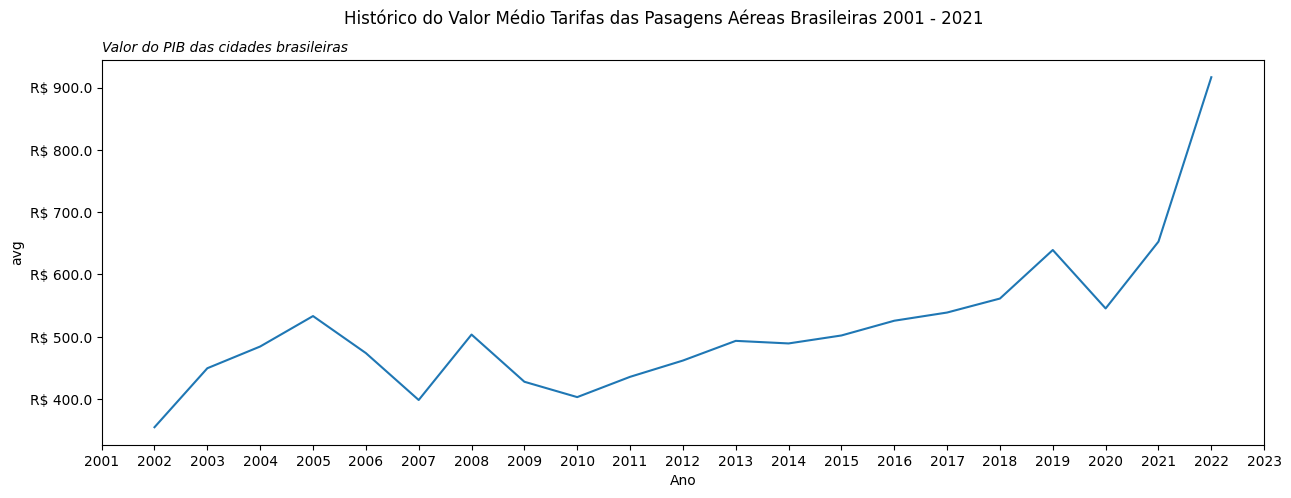

In [21]:


fig = plt.figure(figsize=(15,5))

fig.suptitle("Histórico do Valor Médio Tarifas das Pasagens Aéreas Brasileiras 2001 - 2021")

ax = fig.add_subplot()
ax.set_title('Valor do PIB das cidades brasileiras', loc='left', fontstyle='oblique', fontsize='medium')
sns.lineplot(x='Ano',y='avg',data=g_tarifas)
ax.yaxis.set_major_formatter('R$ {x:1.1f}')
ax.xaxis.set_major_locator(MultipleLocator(1))


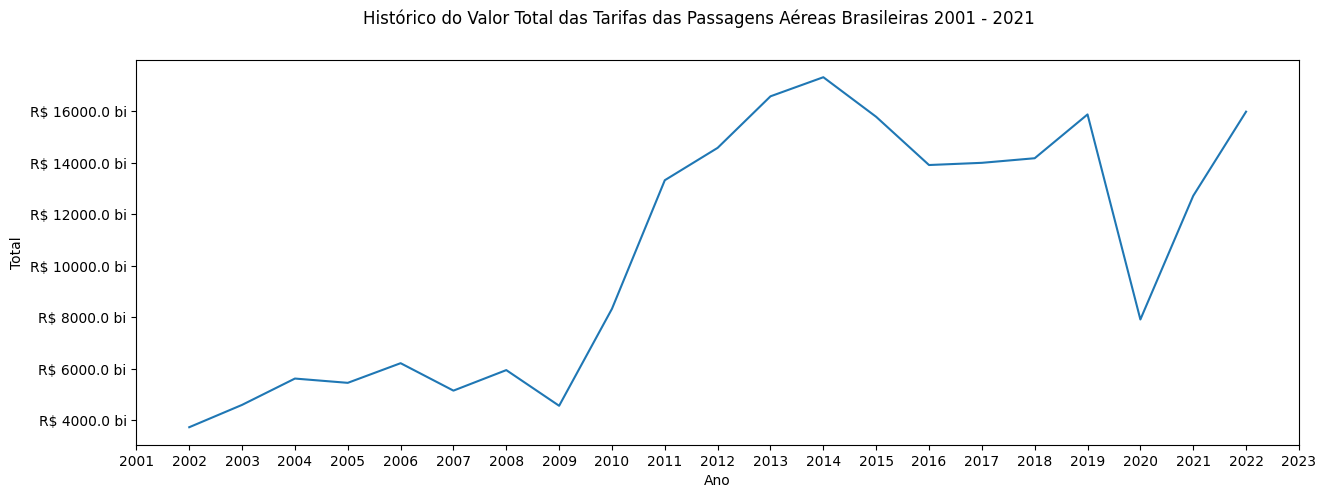

In [22]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot()

fig.suptitle("Histórico do Valor Total das Tarifas das Passagens Aéreas Brasileiras 2001 - 2021")


sns.lineplot(x='Ano',y='Total',data=g_tarifas)
ax.yaxis.set_major_formatter('R$ {x:1.1f} bi')
ax.xaxis.set_major_locator(MultipleLocator(1))

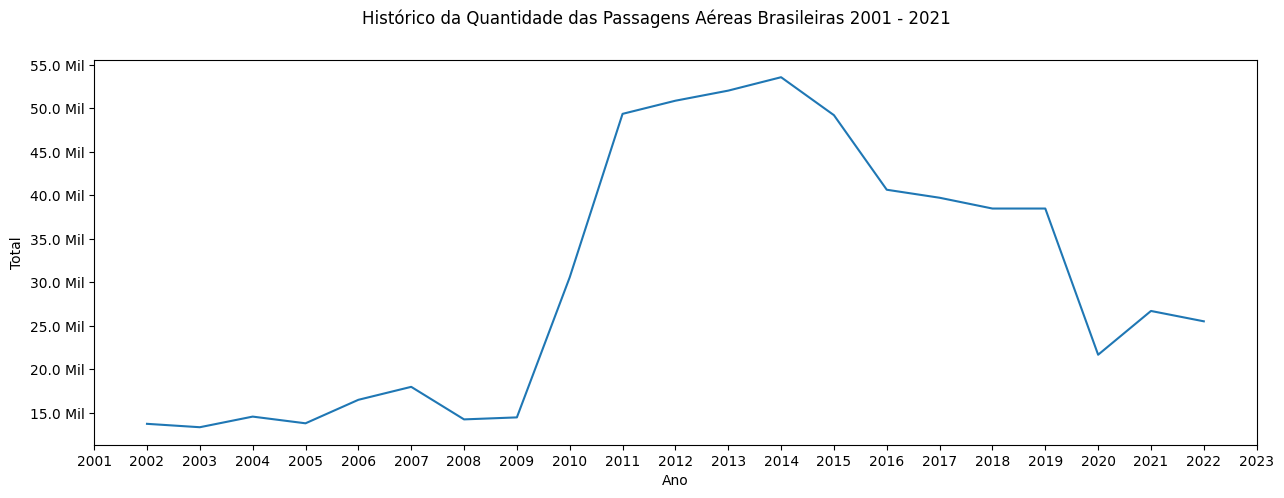

In [23]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot()

fig.suptitle("Histórico da Quantidade das Passagens Aéreas Brasileiras 2001 - 2021")



sns.lineplot(x='Ano',y='Total',data=g_assentos)
ax.yaxis.set_major_formatter('{x:1.1f} Mil')
ax.xaxis.set_major_locator(MultipleLocator(1))

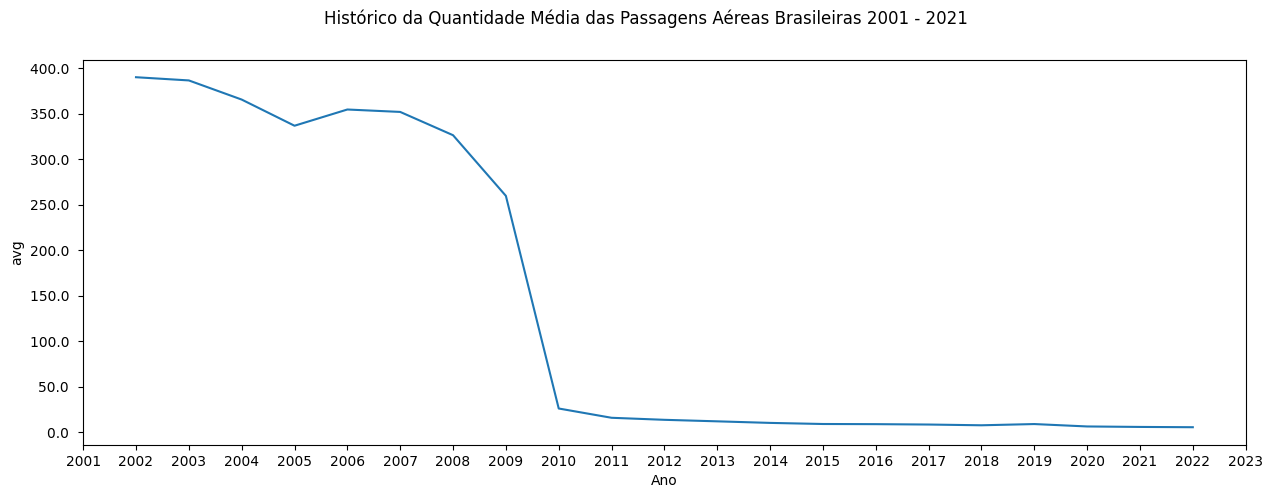

In [24]:

fig = plt.figure(figsize=(15,5))

fig.suptitle("Histórico da Quantidade Média das Passagens Aéreas Brasileiras 2001 - 2021")

ax = fig.add_subplot()

sns.lineplot(x='Ano',y='avg',data=g_assentos)
ax.yaxis.set_major_formatter('{x:1.1f} ')
ax.xaxis.set_major_locator(MultipleLocator(1))

# Aerodromos

## Lendo os Arquivos


In [25]:
pistas = spark.read.csv('/workspaces/TCC_MLaaS_PIB_ANAC/base_dados/Aerodromos/Base_Pistas.csv',header=True)

pistas

DataFrame[OACI: string, CIAD: string, Nome: string, Municipio: string, UF: string, Tipo: string]

## Explorando os Dados

In [26]:
pistas.show(5)

+----+------+--------------------+--------------------+---+-------+
|OACI|  CIAD|                Nome|           Municipio| UF|   Tipo|
+----+------+--------------------+--------------------+---+-------+
|SBAA|PA0008|CONCEIÇÃO DO ARAG...|CONCEIÇÃO DO ARAG...| PA|Publico|
|SBAE|SP0010|       BAURU/AREALVA|               BAURU| SP|Publico|
|SBAQ|SP0012|BARTOLOMEU DE GUSMÃO|          ARARAQUARA| SP|Publico|
|SBAR|SE0001|         SANTA MARIA|             ARACAJU| SE|Publico|
|SBAT|MT0003|PILOTO OSVALDO MA...|       ALTA FLORESTA| MT|Publico|
+----+------+--------------------+--------------------+---+-------+
only showing top 5 rows



## Realizando Join ANAC e Aerodromos

In [27]:
from pyspark.sql.functions import desc

In [35]:
anac_origem = anac
anac_origem.show(5)

+----+---+-------+------+-------+------+--------+--------+
| Ano|Mes|Empresa|Origem|Destino|Tarifa|Assentos|   Total|
+----+---+-------+------+-------+------+--------+--------+
|2002|  1|    GLO|  SBPA|   SBBR| 397.0|      51| 20247.0|
|2002|  1|    GLO|  SBSV|   SBRF| 272.0|       5|  1360.0|
|2002|  1|    GLO|  SBFL|   SBGL| 223.0|     196| 43708.0|
|2002|  1|    GLO|  SBGL|   SBSP|  96.0|     615| 59040.0|
|2002|  1|    GLO|  SBGL|   SBRF| 340.0|     297|100980.0|
+----+---+-------+------+-------+------+--------+--------+
only showing top 5 rows



In [36]:
# Join das cidades de Origem com base nos aeroportos.

anac_origem = (anac_origem\
    .join(pistas,anac_origem.Origem == pistas.OACI,'inner')\
        .drop("OACI", "CIAD","Nome","Tipo")\
            .withColumnRenamed("Municipio","Municipio_Origem")
            .withColumnRenamed("UF","UF_Origem")
)
anac_origem.show(5)

+----+---+-------+------+-------+------+--------+--------+----------------+---------+
| Ano|Mes|Empresa|Origem|Destino|Tarifa|Assentos|   Total|Municipio_Origem|UF_Origem|
+----+---+-------+------+-------+------+--------+--------+----------------+---------+
|2002|  1|    GLO|  SBPA|   SBBR| 397.0|      51| 20247.0|    PORTO ALEGRE|       RS|
|2002|  1|    GLO|  SBSV|   SBRF| 272.0|       5|  1360.0|        SALVADOR|       BA|
|2002|  1|    GLO|  SBFL|   SBGL| 223.0|     196| 43708.0|   FLORIANÓPOLIS|       SC|
|2002|  1|    GLO|  SBGL|   SBSP|  96.0|     615| 59040.0|  RIO DE JANEIRO|       RJ|
|2002|  1|    GLO|  SBGL|   SBRF| 340.0|     297|100980.0|  RIO DE JANEIRO|       RJ|
+----+---+-------+------+-------+------+--------+--------+----------------+---------+
only showing top 5 rows



In [31]:
# Join das cidades de Destino com base nos aeroportos.

df_anac = (anac_origem\
    .join(pistas,anac_origem.Destino == pistas.OACI,'inner')\
        .drop("OACI", "CIAD","Nome","Tipo")\
            .withColumnRenamed("Municipio","Municipio_Destino")
            .withColumnRenamed("UF","UF_Destino")
)
df_anac.show(5)

+----+------+-------+-------------+--------+----------+------------+----------------+---------+--------------------+----------+
| Ano|Origem|Destino| Tarifa_Total|Contagem|Avg_Tarifa|Avg_Assentos|Municipio_Origem|UF_Origem|   Municipio_Destino|UF_Destino|
+----+------+-------+-------------+--------+----------+------------+----------------+---------+--------------------+----------+
|2004|  SBSP|   SBSR|    7219000.0|      77|    457.44|      236.35|       SÃO PAULO|       SP|SÃO JOSÉ DO RIO P...|        SP|
|2005|  SBSV|   SBGL|9.321448377E7|     456|    624.61|      409.55|        SALVADOR|       BA|      RIO DE JANEIRO|        RJ|
|2005|  SBBR|   SBBH|1.131254676E7|     179|    419.25|      216.37|        BRASÍLIA|       DF|      BELO HORIZONTE|        MG|
|2006|  SBPA|   SBCT|4.595667721E7|     491|    347.39|      336.66|    PORTO ALEGRE|       RS|            CURITIBA|        PR|
|2007|  SBRP|   SBSP|1.027435421E7|     205|    292.53|      294.57|  RIBEIRÃO PRETO|       SP|         